In [4]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_folder = 'data'

Load all the data and append them into one dataframe
Due to storage concerns, we will be sampling instead.

In [5]:
try:
    files = Path.glob(Path(data_folder), "yellow_tripdata*")
    num_sample = 1000000

    dfs = []
    for file in files:
        temp = pd.read_parquet(file)
        print(f"{file} has {len(temp)} entries - sampling {num_sample} from them.")
        dfs.append(temp.sample(num_sample, random_state=42))

    df = pd.concat(dfs)
except:
    df = pd.read_parquet('tripdata_combined.parquet')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23000000 entries, 2790731 to 1057964
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

Data cleaning

In [7]:
# Remove entries where the total amount paid is <= 0 (refunds/cancelled rides)
df = df[df['total_amount'] > 0]

# Remove other entries with negative tips
df = df[df['tip_amount'] >= 0]

# Remove extreme outliers (tips above $100 and trip distances above 100 miles)
df = df[df['tip_amount'] < 100]
df = df[df['trip_distance'] < 100]

Get time of day, day of week, and season when the pickup occured

In [8]:
# Convert to datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Define time of day
def get_time_of_day(hour):
    if 5 <= hour < 11:
        return "Morning"
    elif 11 <= hour < 17:
        return "Noon/Afternoon"
    elif 17 <= hour < 23:
        return "Evening"
    else:
        return "Night"

df['time_of_day'] = df['tpep_pickup_datetime'].dt.hour.apply(get_time_of_day)

# Get Day of Week
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df['season'] = df['tpep_pickup_datetime'].dt.month.apply(get_season)

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee,time_of_day,day_of_week,season
2790731,2,2023-01-29 17:52:02,2023-01-29 17:56:43,1.0,1.17,1.0,N,262,74,2,...,0.00,0.0,1.0,11.20,2.5,0.0,NaN,Evening,Sunday,Winter
666153,1,2023-01-08 15:57:24,2023-01-08 16:02:47,1.0,0.90,1.0,N,229,237,2,...,0.00,0.0,1.0,10.50,2.5,0.0,NaN,Noon/Afternoon,Sunday,Winter
1985683,2,2023-01-21 19:38:01,2023-01-21 19:45:02,1.0,0.95,1.0,N,45,261,1,...,2.38,0.0,1.0,14.28,2.5,0.0,NaN,Evening,Saturday,Winter
2154231,2,2023-01-23 16:07:31,2023-01-23 16:26:46,5.0,0.88,1.0,N,237,141,1,...,1.50,0.0,1.0,24.30,2.5,0.0,NaN,Noon/Afternoon,Monday,Winter
2493619,2,2023-01-26 21:21:08,2023-01-26 21:24:48,2.0,1.03,1.0,N,229,140,1,...,2.30,0.0,1.0,13.80,2.5,0.0,NaN,Evening,Thursday,Winter


Save data into one parquet file

In [10]:
df.to_parquet("tripdata_combined.parquet")

Load data from parquet file

In [11]:
df = pd.read_parquet("tripdata_combined.parquet")
print(df.head().to_markdown())
print("Shape of data", df.shape)

|         |   VendorID | tpep_pickup_datetime   | tpep_dropoff_datetime   |   passenger_count |   trip_distance |   RatecodeID | store_and_fwd_flag   |   PULocationID |   DOLocationID |   payment_type |   fare_amount |   extra |   mta_tax |   tip_amount |   tolls_amount |   improvement_surcharge |   total_amount |   congestion_surcharge |   airport_fee |   Airport_fee | time_of_day    | day_of_week   | season   |
|--------:|-----------:|:-----------------------|:------------------------|------------------:|----------------:|-------------:|:---------------------|---------------:|---------------:|---------------:|--------------:|--------:|----------:|-------------:|---------------:|------------------------:|---------------:|-----------------------:|--------------:|--------------:|:---------------|:--------------|:---------|
| 2790731 |          2 | 2023-01-29 17:52:02    | 2023-01-29 17:56:43     |                 1 |            1.17 |            1 | N                    |            262

Data visualization

KeyboardInterrupt: 

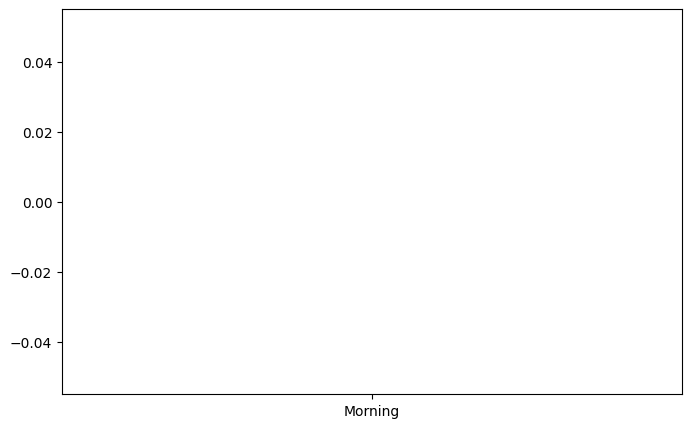

In [12]:
# Violin plots for tipping amount with respect to times (with outliers)
plt.figure(figsize=(8, 5))
sns.violinplot(x="time_of_day", y='tip_amount', data=df, order=["Morning", "Noon/Afternoon", "Evening", "Night"])
plt.xlabel("Time of Day")
plt.ylabel("Tip amount ($)")
plt.title("Tip Amount Variation by Time of Day")

plt.figure(figsize=(8, 5))
sns.violinplot(x="day_of_week", y='tip_amount', data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Day of Week")
plt.ylabel("Tip amount ($)")
plt.title("Tip Amount Variation by Day of Week")

plt.figure(figsize=(8, 5))
sns.violinplot(x="season", y='tip_amount', data=df, order=["Winter", "Spring", "Summer", "Fall"])
plt.xlabel("Season")
plt.ylabel("Tip amount ($)")
plt.title("Tip Amount Variation by Season")
plt.show()

In [ ]:
# Violin plots for tipping amount with respect to times (without outliers) (Caution: needs lots of RAM)

temp = df[df['tip_amount'] < 6.51]  # Non-outlier entries

plt.figure(figsize=(8, 5))
sns.violinplot(x="time_of_day", y='tip_amount', data=temp, order=["Morning", "Noon/Afternoon", "Evening", "Night"])
plt.xlabel("Time of Day")
plt.ylabel("Tip amount ($)")
plt.title("Tip Amount Variation by Time of Day")

plt.figure(figsize=(8, 5))
sns.violinplot(x="day_of_week", y='tip_amount', data=temp, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Day of Week")
plt.ylabel("Tip amount ($)")
plt.title("Tip Amount Variation by Day of Week")

plt.figure(figsize=(8, 5))
sns.violinplot(x="season", y='tip_amount', data=temp, order=["Winter", "Spring", "Summer", "Fall"])
plt.title("Tip Amount Variation by Season")
plt.xlabel("Season")
plt.ylabel("Tip amount ($)")
plt.show()

In [ ]:
# Violin plots for tip amounts for credit vs cash payments

temp = df[np.logical_or(df['payment_type'] == 1, df['payment_type'] == 2)]  # Select entries paid in cash or credit

plt.figure(figsize=(8, 5))
sns.violinplot(x=temp['payment_type'].map({1: 'Credit Card', 2: 'Cash'}), y='tip_amount', data=temp)
plt.xlabel("Payment Type")
plt.ylabel("Tip amount ($)")
plt.title("Tip Amount for Credit vs Cash")

temp = temp[temp['tip_amount'] < 6.51]  # Non-outlier entries
plt.figure(figsize=(8, 5))
sns.violinplot(x=temp['payment_type'].map({1: 'Credit Card', 2: 'Cash'}), y='tip_amount', data=temp)
plt.xlabel("Payment Type")
plt.ylabel("Tip amount ($)")
plt.title("Tip Amount for Credit vs Cash (No outliers)")
plt.show()

In [ ]:
df[df['payment_type'] == 1]['tip_amount'].describe()

In [ ]:
df[df['payment_type'] == 2]['tip_amount'].describe()

In [ ]:
df['tipped'] = (df['tip_amount'] > 0).astype(int)

# Define distance bins
bin_edges = np.linspace(df['trip_distance'].min(), df['trip_distance'].max(), 30)  # 30 bins
df['distance_bin'] = pd.cut(df['trip_distance'], bins=bin_edges, include_lowest=True)

# Compute percentage of people who tipped in each bin
tip_percentage = df.groupby('distance_bin')['tipped'].mean() * 100
bin_centers = [interval.mid for interval in tip_percentage.index]  # Get bin centers for plotting

plt.figure(figsize=(8,5))
plt.plot(bin_centers, tip_percentage, marker='o', linestyle='-', color='blue')

plt.xlabel("Trip Distance")
plt.ylabel("Percentage of People Who Tipped (%)")
plt.title("Tipping Rate vs. Trip Distance")
plt.grid(True)
plt.show()

In [ ]:
df['trip_distance'].describe()